In [1]:
import meds
import fitsio
import proplot as pplt
import subprocess
import glob
import os
import numpy as np
import yaml

In [2]:
dcat = fitsio.read(os.path.expandvars("$MEDS_DIR/input_cosmos_v4.fits"))

msk = (
    (dcat["mask_flags"] == 0)
    & (dcat["isgal"] == 1)
    & (dcat["bdf_hlr"] > 0)
    & (dcat["bdf_hlr"] < 5)
    & (dcat["mag_i"] <= 25)
)

dcat = dcat[msk]

(array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 4.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 5.000e+00,
        3.000e+00, 1.200e+01, 7.000e+00, 1.300e+01, 1.300e+01, 1.900e+01,
        2.700e+01, 2.300e+01, 2.100e+01, 3.800e+01, 4.000e+01, 4.200e+01,
        3.900e+01, 4.600e+01, 5.100e+01, 7.700e+01, 6.600e+01, 1.040e+02,
        8.600e+01, 9.100e+01, 1.180e+02, 1.370e+02, 1.420e+02, 1.300e+02,
        1.520e+02, 1.590e+02, 1.770e+02, 2.030e+02, 2.040e+02, 2.040e+02,
        2.250e+02, 2.660e+02, 3.130e+02, 2.900e+02, 3.160e+02, 3.020e+02,
        4.010e+02, 3.730e+02, 3.980e+02, 4.150e+02, 5.080e+02, 4.790e+02,
        5.540e+02, 5.220e+02, 6.180e+02, 6.670e+02, 6.780e+02, 7.190e+02,
        6.950e+02, 8.210e+02, 8.500e+02, 9.590e+02, 9.530e+02, 1.041e+03,
        1.094e+03, 1.133e+03, 1.184e+03, 1.326e+03, 1.322e+03, 1.507e+03,
        1.466e+03, 1.595e+03, 1.734e+03, 1.833e+03, 1.930e+03, 2.018e+03,
        2.141e+03, 2.331e+03, 2.466e+0

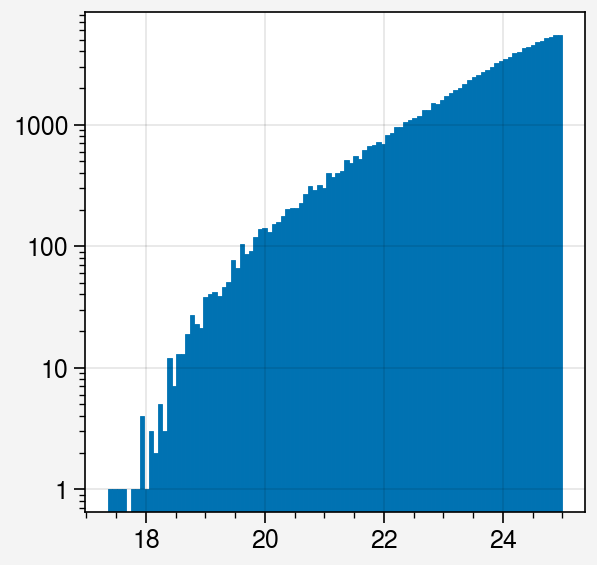

In [3]:
fig, axs = pplt.subplots()

axs.hist(dcat["mag_i"], bins=100, log=True)

In [4]:
def _download_tile(tilename, cwd):
    os.system("mkdir -p data")

    d = fitsio.read(
        os.path.join(cwd, "fnames.fits"),
        lower=True,
    )
    tnames = np.array([
        d["filename"][i].split("_")[0]
        for i in range(d.shape[0])
    ])
    msk = tnames == tilename
    if np.sum(msk) != 4:
        return np.sum(msk)

    d = d[msk]
    mfiles = []
    for band in ["g", "r", "i", "z"]:
        msk = d["band"] == band
        if np.any(msk):
            _d = d[msk]
            for i in range(len(_d)):
                fname = os.path.join(d["path"][msk][i], d["filename"][msk][i])
                cmd = """\
        rsync \
                -av \
                --password-file $DES_RSYNC_PASSFILE \
                ${DESREMOTE_RSYNC_USER}@${DESREMOTE_RSYNC}/%s \
                ./data/%s
        """ % (fname, os.path.basename(fname))
                subprocess.run(cmd, shell=True, check=True)
            mfiles.append("./data/%s" % os.path.basename(fname))

    return mfiles


In [5]:
fnames = sorted(glob.glob("./data_final/*.fits"))

In [6]:
find = 10
tilename = os.path.basename(fnames[find]).split("_")[0]
mfiles = _download_tile(tilename, ".")


    DES rsync daemon

receiving incremental file list

sent 19 bytes  received 100 bytes  79.33 bytes/sec
total size is 864645120  speedup is 7265925.38

    DES rsync daemon

receiving incremental file list

sent 19 bytes  received 100 bytes  238.00 bytes/sec
total size is 859864320  speedup is 7225750.59

    DES rsync daemon

receiving incremental file list

sent 19 bytes  received 100 bytes  79.33 bytes/sec
total size is 824238720  speedup is 6926375.80

    DES rsync daemon

receiving incremental file list

sent 19 bytes  received 100 bytes  238.00 bytes/sec
total size is 845616960  speedup is 7106024.87


## Try Deepfields

In [7]:
m = meds.MEDS(mfiles[2])

In [8]:
import galsim

def _get_object(rng, dcat):
    rind = rng.randint(low=0, high=m.size-1)
    return (
        (1.0 - dcat["bdf_fracdev"][rind]) * galsim.Sersic(n=1, half_light_radius=dcat["bdf_hlr"][rind])
        + dcat["bdf_fracdev"][rind] * galsim.Sersic(n=4, half_light_radius=dcat["bdf_hlr"][rind])
    ).shear(
        g1=dcat["bdf_g1"][rind], g2=dcat["bdf_g2"][rind]
    ).rotate(
        rng.uniform() * 360.0*galsim.degrees
    ).withFlux(
        dcat["flux_i"][rind]
    )

In [37]:
import ngmix

def _make_obs(gal, psf_im, nse, rng, n=49):
    psf = galsim.InterpolatedImage(galsim.ImageD(psf_im), scale=0.263)
    im = galsim.Convolve([gal, psf]).drawImage(nx=n, ny=n, scale=0.263, method="no_pixel").array
    psf_im = psf.drawImage(nx=n, ny=n, scale=0.263, method="no_pixel").array
    cen = (n-1)/2
    
    im += rng.normal(size=im.shape, scale=nse)
    
    obs = ngmix.Observation(
        image=im,
        weight=np.ones_like(im)/nse**2,
        jacobian=ngmix.DiagonalJacobian(scale=0.263, row=cen, col=cen),
        psf=ngmix.Observation(
            image=psf_im,
            weight=np.ones_like(im),
            jacobian=ngmix.DiagonalJacobian(scale=0.263, row=cen, col=cen),
        ),
    )
    return obs


In [ ]:
import tqdm
from ngmix.prepsfmom import PGaussMom
from mattspy.stats import mad
import joblib

rng = np.random.RandomState(seed=1900)

wgt_cache = {}

def _draw_noise(rng, m):
    rind = rng.randint(low=0, high=m.size-1)
    while m["ncutout"][rind] < 1:
        rind = rng.randint(low=0, high=m.size-1)
    if rind not in wgt_cache:
        wgt_cache[rind] = 1.0/np.sqrt(np.median(m.get_cutout(rind, 0, type="weight")))
        
    return wgt_cache[rind], m.get_cutout(rind, 0, type="psf")


def _meas(gal, psf, nse, aps):
    obs = _make_obs(
        gal,
        psf,
        nse,
        rng,
    )
    s2ns = []
    g1s = []
    flags = []
    for ap in aps:
        mom = PGaussMom(ap).go(obs)
        flags.append(mom["flags"])
        s2ns.append(mom["s2n"])
        g1s.append(mom["e1"])
        
    return s2ns, g1s, flags
    
aps = np.linspace(1.5, 2.5, 5)
jobs = []
for i in tqdm.trange(50000):
    gal = _get_object(rng, dcat)
    nse, psf = _draw_noise(rng, m)
    jobs.append(joblib.delayed(_meas)(gal, psf, nse, aps))

with joblib.Parallel(n_jobs=-1, verbose=10) as par:
    outputs = par(jobs)

In [47]:
meas = []
g1_meas = []
all_flags = []
for out in outputs:
    s2ns, g1s, flags = out
    if any(_s > 10 for _s in s2ns) and all(f == 0 for f in flags):
        meas.append(s2ns)
        g1_meas.append(g1s)
    all_flags.append(flags)

print(len(meas), np.mean(np.array(all_flags) == 0, axis=0))
print(len(meas), aps)
print(len(meas), np.bincount(np.argmax(meas, axis=1))/len(meas))
print(len(meas), mad(g1_meas, axis=0))

22932 [0.98844 0.99902 0.99974 0.99988 1.      1.      1.      1.      1.
 0.99996]
22932 [1.         1.11111111 1.22222222 1.33333333 1.44444444 1.55555556
 1.66666667 1.77777778 1.88888889 2.        ]
22932 [0.         0.         0.         0.         0.00082854 0.04461015
 0.19501134 0.22972266 0.18541776 0.34440956]
22932 [0.23214718 0.18986352 0.21210025 0.27137612 0.31685588 0.33941038
 0.34992441 0.35359762 0.35247996 0.34377154]


Text(0.5, 0, 'pgauss FWHM [arcsec]')

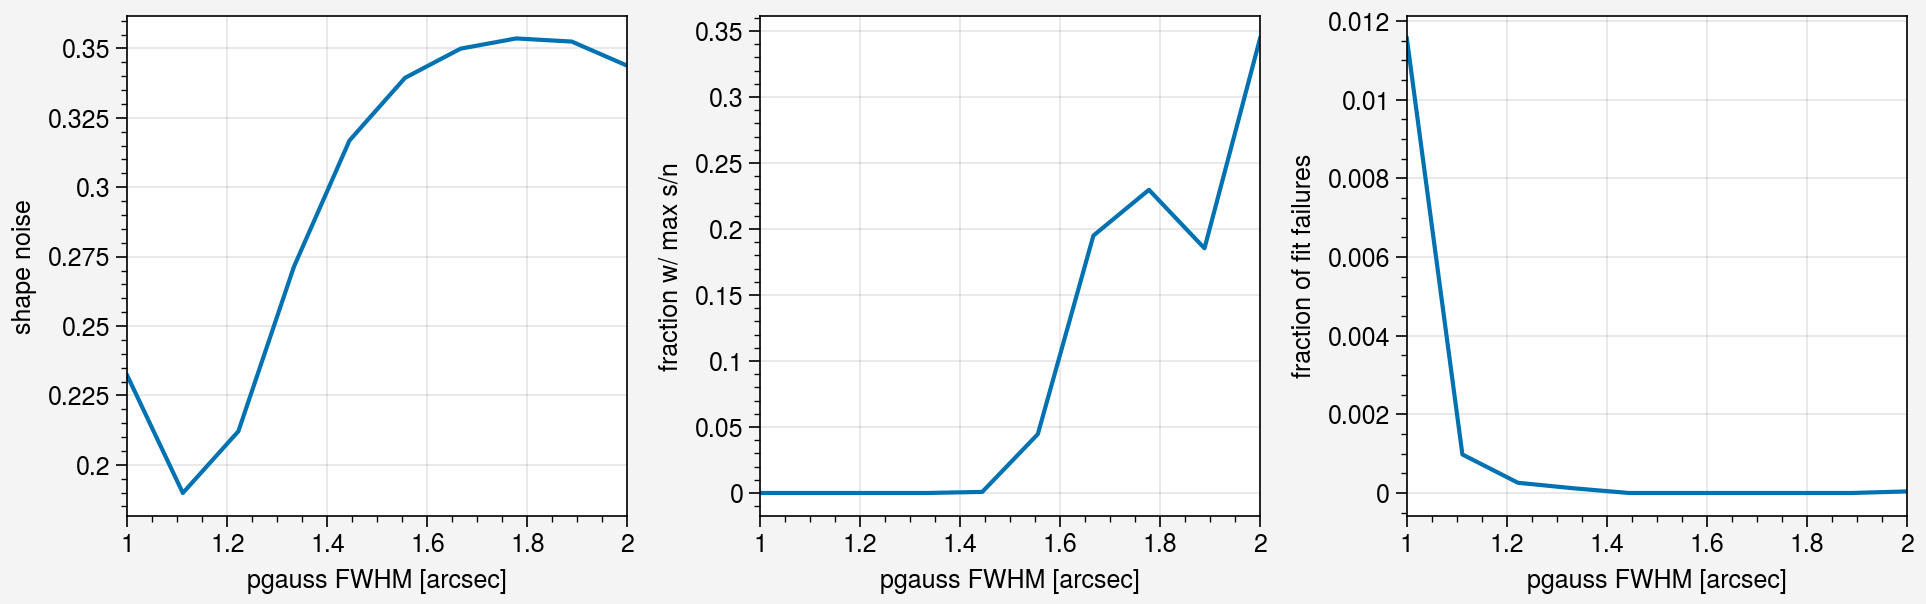

In [48]:
fig, axs = pplt.subplots(nrows=1, ncols=3, share=0)

axs[0].plot(
    aps,
    mad(g1_meas, axis=0),
)
axs[0].set_ylabel("shape noise")
axs[0].set_xlabel("pgauss FWHM [arcsec]")

axs[1].plot(
    aps,
    np.bincount(np.argmax(meas, axis=1))/len(meas),
)
axs[1].set_ylabel("fraction w/ max s/n")
axs[1].set_xlabel("pgauss FWHM [arcsec]")

axs[2].plot(
    aps,
    1.0 - np.mean(np.array(all_flags) == 0, axis=0),
)
axs[2].set_ylabel("fraction of fit failures")
axs[2].set_xlabel("pgauss FWHM [arcsec]")


## Use MEDS objects

In [ ]:
cfg = """\
model: pgauss

metacal:
  psf: fitgauss
  types: [noshear, 1p, 1m, 2p, 2m]
  use_noise_image: True

# use defaults in sxdes package
sx: null

weight:
  fwhm: 2.0  # arcsec

# any regions where the bmask is set with one of these flags will be masked
# out of detection
nodet_flags: 33554432  # 2**25 is GAIA stars

# check for hitting the edge when fitting
bmask_flags: 1610612736  # 2**29 | 2**30 edge in either MEDS of pizza cutter

mfrac_fwhm: 2  # arcsec

meds:
  box_padding: 2
  box_type: iso_radius
  max_box_size: 96
  min_box_size: 96
  rad_fac: 2
  rad_min: 4

pizza-cutter-preprocessing:
  gaia_star_masks:
    poly_coeffs: [ 1.36055007e-03, -1.55098040e-01,  3.46641671e+00]
    max_g_mag: 18.0
    symmetrize: False
    # interp:
    #   fill_isolated_with_noise: False
    #   iso_buff: 1
    apodize:
      ap_rad: 1
    mask_expand_rad: 16

  slice_apodization:
    ap_rad: 1
"""

cfg = yaml.safe_load(cfg)

In [ ]:
import tqdm
from metadetect import detect
from ngmix.medsreaders import MultiBandNGMixMEDS, NGMixMEDS
from ngmix.prepsfmom import PGaussMom

meds_list = []
for f in mfiles:
    m = NGMixMEDS(f)
    meds_list.append(m)

mbmeds = MultiBandNGMixMEDS(meds_list)

aps = [1.5, 1.75, 2.0, 2.25]
meas = []

for i in tqdm.trange(200):
    mbobs = mbmeds.get_mbobs(i)
    medsifier = detect.MEDSifier(
        mbobs=mbobs,
        sx_config=None,
        meds_config=cfg['meds'],
        nodet_flags=0,
    )
    mbm = medsifier.get_multiband_meds()
    mbobs_list = mbm.get_mbobs_list()
    
    for mbobs in mbobs_list:
        s2ns = []
        for ap in aps:
            s2ns.append(PGaussMom(ap).go(mbobs[2][0])["s2n"])
        if any(_s > 10 for _s in s2ns):
            meas.append(s2ns)
    
    if (i+1) % 10 == 0:
        print(i, np.bincount(np.argmax(meas, axis=1))/len(meas))